In [160]:
from pathlib import Path
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from watermark import watermark
import missingno as msno
import dataframe_image as dfi

import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=UserWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", category=RuntimeWarning)

### **Definições Gerais**

In [161]:
DIR_RAIZ = "/home/asoares/Insync/alexandre.asoares@gmail.com/OneDrive/Atividades/LocalCases/Desenvolvendo/CramerV/Dataset"
NOME_DATASET = "Customer-Churn.csv"

ARQUIVO_DATASET = str(Path(DIR_RAIZ, NOME_DATASET))
BUG = False
SEMENTE = 1965
Componentes = [ "gender", "Partner", "Dependents", "PhoneService",
                "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
                "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
                "Contract", "PaperlessBilling", "PaymentMethod", "Churn"]

pd.set_option('max_colwidth', 800)

### **Funções Necessárias**

In [162]:
def VerificaCategorico (Componente):
    TipoCategoria = ['object', 'category', 'bool', 'int64']
    if Componente.dtype.name in TipoCategoria:
        return "Sim"
    else:
        return "Não"

In [163]:

# import pandas as pd
# from dataframe_to_image import dataframe_to_image

def MapaDados ( tempdfDados ):
    tempComponentes = tempdfDados.columns
    tempComponentes = tempComponentes.drop(tempComponentes[0])

    TipoColunas = tempdfDados.dtypes
    TipoColunas = TipoColunas.drop(TipoColunas.index[0])
    ExcecaoColunas = ['tenure', 'MonthlyCharges', 'TotalCharges']
    dfTemp = pd.DataFrame({'Componente':TipoColunas.index, 'Tipo':TipoColunas.values, "Categorico":"", "Valor Categorico":"", "Minimo":"", "Maximo":""})

    for iAux in range(0, len(tempComponentes)):
        dfTemp["Minimo"][iAux] = np.min(dfOriginal[tempComponentes[iAux]])
        dfTemp["Maximo"][iAux] = np.max(dfOriginal[tempComponentes[iAux]])

        if any(tempComponentes[iAux] in iLista for iLista in ExcecaoColunas):
            dfTemp["Valor Categorico"][iAux] = "[N/A]"
            dfTemp["Categorico"][iAux] = "Não"
        else:
          iValor = pd.unique(dfOriginal[tempComponentes[iAux]].values.ravel())
          dfTemp["Valor Categorico"][iAux] = iValor.tolist()
          dfTemp["Categorico"][iAux] = VerificaCategorico (dfOriginal[tempComponentes[iAux]])

    dfTemp.dfi.export("/home/asoares/Desktop/df_styled.png")
    return (dfTemp)

In [164]:
def VerificaErros (tempOriginal, tempDados, tempCampo):
    lstOriginal = []
    lstResultado = []

    CamposUnicos = tempOriginal[tempCampo].unique()
    for iAux in range (0, len(CamposUnicos)):
        Resultado = tempOriginal[tempOriginal[tempCampo]==CamposUnicos[iAux]].shape[0]
        lstOriginal.append (Resultado)

    CamposUnicos = tempDados[tempCampo].unique()
    for iAux in range (0, len(CamposUnicos)):
        Resultado = tempDados[tempDados[tempCampo]==CamposUnicos[iAux]].shape[0]
        lstResultado.append (Resultado)

    iTotal = 0
    for iAux in range (0, len(lstOriginal)):
        if ( lstOriginal[iAux] == lstResultado[iAux] ):
            iTotal = iTotal + 1

    if ( iTotal == len(lstOriginal)):
        Mensagem = "Sucesso"
    else:
        Mensagem = "Falha"

    return (Mensagem)

In [165]:
def DesenhaDensidades (dfDadosTemp, ComponenteTemp ):
    Grafico = plt.figure( figsize=(8, 5))
    sns.set_style("darkgrid")
    sns.kdeplot ( x = dfDadosTemp[ComponenteTemp], lw=2, shade=True, hue = dfDadosTemp["Churn"] )
    plt.title("Distribuição de Densidades", fontsize=11, fontweight="bold")
    plt.ylabel("Densidade", fontsize=11, fontweight="bold")
    plt.xlabel(ComponenteTemp, fontsize=11, fontweight="bold")
    plt.show()
    return

In [166]:
def CalculaPerdas ( dfDadosTemp ):
    dfChurn = dfDados [dfDados["Churn"] == 1]
    dfChurn = dfChurn.reset_index()

    dfCliente = dfDados [dfDados["Churn"] == 0]
    dfCliente = dfCliente.reset_index()
    PerdaChurn = 0.0
    for iAux in range(0,len(dfChurn)):
        Meses = dfChurn["tenure"][iAux]
        Total = dfChurn["TotalCharges"][iAux]
        PerdaChurn = PerdaChurn + (Total / Meses)

    TamanhoGanho = 0.0
    for iAux in range(0,len(dfCliente)):
        Meses = dfCliente["tenure"][iAux]
        Total = dfCliente ["TotalCharges"][iAux]
        if ( Meses > 0 and Total > 0):
          TamanhoGanho = TamanhoGanho + (Total / Meses)

    return (PerdaChurn, TamanhoGanho)

In [167]:
def MinhaFuncao (pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

In [168]:
def DesenhaPizza (dfChurnTemp, dfClienteTemp, ComponenteTemp, Titulo1, Titulo2, LegendaTemp):
    Grafico = plt.figure( figsize=(10, 8))
    sns.set_style("darkgrid")

    lstQuantidade = []
    Tamanho = len (pd.unique( dfClienteTemp[ComponenteTemp].values.ravel()))
    for iAux in range (0, Tamanho):
        lstQuantidade.append (dfClienteTemp[dfClienteTemp[ComponenteTemp]==iAux].shape[0])

    Grafico.add_subplot(1, 2, 1 )
    plt.title(Titulo1, fontsize=11, fontweight="bold")

    plt.pie (
            lstQuantidade,
            textprops=dict(color="w"),
            autopct=lambda pct: MinhaFuncao(pct,lstQuantidade),
            startangle=0,
            wedgeprops = {
                            "linewidth" : 3,
                            "edgecolor" : "black"
                         },
            )
    plt.legend(LegendaTemp, bbox_to_anchor = (0.1, .3))

    lstQuantidade = []
    Tamanho = len (pd.unique( dfChurnTemp[ComponenteTemp].values.ravel()))
    for iAux in range (0, Tamanho):
        lstQuantidade.append (dfChurnTemp[dfChurnTemp[ComponenteTemp]==iAux].shape[0])

    Grafico.add_subplot(1, 2, 2 )
    plt.title(Titulo2, fontsize=11, fontweight="bold")

    plt.pie (
            lstQuantidade,
            textprops=dict(color="w"),
            autopct=lambda pct: MinhaFuncao(pct,lstQuantidade),
            startangle=0,
            wedgeprops = {
                            "linewidth" : 3,
                            "edgecolor" : "black"
                         },
            )

    plt.legend(LegendaTemp, bbox_to_anchor = (0.1, .3))

    plt.show()
    return


In [169]:
def ContaClientes ( dfDadosTemp ):
    dfChurn = dfDadosTemp [dfDadosTemp["Churn"] == 1]
    dfChurn = dfChurn.reset_index()

    dfCliente = dfDadosTemp [dfDadosTemp["Churn"] == 0]
    dfCliente = dfCliente.reset_index()

    ClientesPerdidos = dfChurn ["customerID"].count ()
    ClientesAtuais = dfCliente ["customerID"].count ()

    return ( ClientesPerdidos, ClientesAtuais )

In [170]:
def MontaPizza ( Labels, Quantidade, Titulo ):
    Grafico = plt.figure( figsize=(6, 4))
    sns.set_style("darkgrid")

    plt.title(Titulo, fontsize=11, fontweight="bold")
    plt.pie (
            Quantidade,
            labels = Labels,
            autopct = "%1.2f%%",
            wedgeprops = {
                            "linewidth" : 3,
                            "edgecolor" : "black"
                        },
            startangle=90
            )

    plt.axis("equal")
    plt.tight_layout()
    plt.show()
    return

# **Leitura dos Dados**

In [171]:

try:
    dfOriginal = pd.read_csv( ARQUIVO_DATASET, decimal=",")

except FileNotFoundError:
    print ( "Não Foi Localizado o Dataset:", NOME_DATASET)
    exit ()

except pd.errors.EmptyDataError:
    print (f"Dataset {NOME_DATASET} Está Vazio")
    exit ()

except pd.errors.ParserError:
    print ( f"Erro no Parsing do Dataset {NOME_DATASET}")
    exit ()

except Exception:
    print ( f"Occoreu uma Exceção no Dataset: {NOME_DATASET}")
    exit ()


## **Verificando se Existem Dados Duplicados**

In [172]:
Duplicados = dfOriginal.duplicated().sum()
print ("#####################################################################")
print ("# Verificação de Dados Duplicados")
print ("#####################################################################")
Avaliacao = "Não Há Dados Dupĺicados"
if ( Duplicados >= 1):
    Avaliacao = "Existem Dados Dupĺicados"
print ( "# ", Avaliacao )
print ("#####################################################################")
del (Duplicados, Avaliacao)

#####################################################################
# Verificação de Dados Duplicados
#####################################################################
#  Não Há Dados Dupĺicados
#####################################################################


## **Estrutura das Componentes do Dataset**

In [173]:
MapaDados (dfOriginal)


,Componente,Tipo,Categorico,Valor Categorico,Minimo,Maximo
0,gender,object,Sim,"[Female, Male]",Female,Male
1,SeniorCitizen,int64,Sim,"[0, 1]",0,1
2,Partner,object,Sim,"[Yes, No]",No,Yes
3,Dependents,object,Sim,"[Yes, No]",No,Yes
4,tenure,int64,Não,[N/A],0,72
5,PhoneService,object,Sim,"[Yes, No]",No,Yes
6,MultipleLines,object,Sim,"[Yes, No, No phone service]",No,Yes
7,InternetService,object,Sim,"[Fiber optic, DSL, No]",DSL,No
8,OnlineSecurity,object,Sim,"[Yes, No, No internet service]",No,Yes
9,OnlineBackup,object,Sim,"[Yes, No, No internet service]",No,Yes


## **Avaliação da Cardinalidade dos Dados**

In [174]:
dfCardinalidade = dfOriginal.nunique()
dfCardinalidade = pd.DataFrame ({
                                'Componente':dfCardinalidade.index,
                                'Variabilidade':dfCardinalidade.values
                               })

print ("#####################################################################")
print ("# Avaliação da Cardinalidade")
print ("#####################################################################")

Cabecalho = [ "Componente", "Variabilidade", "Avaliação"]
print(f"{Cabecalho[0]: <17} {Cabecalho[1]: <15} {Cabecalho[2]: <25}")

for iAux in range (len(dfCardinalidade)):

    Avaliacao = "Baixa Cardinalidade"
    if ( dfCardinalidade ["Variabilidade"][iAux] > 1):
       Avaliacao = "Cardinalidade Presente"

    jAux = dfCardinalidade["Componente"][iAux]
    kAux = dfCardinalidade ["Variabilidade"][iAux]

    print(f"{jAux: <17} {kAux: <15} {Avaliacao: <25}")

print ("#####################################################################")

del (Cabecalho, iAux, Avaliacao, jAux, dfCardinalidade, kAux)


#####################################################################
# Avaliação da Cardinalidade
#####################################################################
Componente        Variabilidade   Avaliação                
customerID        7043            Cardinalidade Presente   
gender            2               Cardinalidade Presente   
SeniorCitizen     2               Cardinalidade Presente   
Partner           2               Cardinalidade Presente   
Dependents        2               Cardinalidade Presente   
tenure            73              Cardinalidade Presente   
PhoneService      2               Cardinalidade Presente   
MultipleLines     3               Cardinalidade Presente   
InternetService   3               Cardinalidade Presente   
OnlineSecurity    3               Cardinalidade Presente   
OnlineBackup      3               Cardinalidade Presente   
DeviceProtection  3               Cardinalidade Presente   
TechSupport       3               Cardinalidade Pre

# **Aumentando a Qualidade dos Dados**

## **Convertendo a Base Para Uppercase**

In [175]:
dfDados = dfOriginal.copy()
for iComponente in Componentes:
    dfDados[iComponente] = dfDados[iComponente].apply(lambda x: x.upper())

del (iComponente)

## **Codificando os Labels do Dataset**

In [176]:
EncoderComponente = LabelEncoder()
for iComponente in Componentes:
    dfDados[iComponente] = EncoderComponente.fit_transform(dfDados[iComponente])

del (EncoderComponente, iComponente )

## **Verificando Possíveis Erros No Processo de Codificação**

In [177]:
print ("########################################################################")
print ("# Verificando Possíveis Erros No Processo de Codificação")
print ("########################################################################")

Cabecalho = [ "Campo do Dataset", "Resultado da Avaliação"]
print(f"{Cabecalho[0]: <25} {Cabecalho[1]: <25}")
print ("########################################################################")
for iAux in range (len(Componentes)):
    print(f"# {Componentes[iAux]: <25} {VerificaErros (dfOriginal, dfDados, Componentes[iAux]): <25}")

print ("########################################################################")

del (Cabecalho, iAux)

########################################################################
# Verificando Possíveis Erros No Processo de Codificação
########################################################################
Campo do Dataset          Resultado da Avaliação   
########################################################################
# gender                    Sucesso                  
# Partner                   Sucesso                  
# Dependents                Sucesso                  
# PhoneService              Sucesso                  
# MultipleLines             Sucesso                  
# InternetService           Sucesso                  
# OnlineSecurity            Sucesso                  
# OnlineBackup              Sucesso                  
# DeviceProtection          Sucesso                  
# TechSupport               Sucesso                  
# StreamingTV               Sucesso                  
# StreamingMovies           Sucesso                  
# Contract              

# **Análise de Exploração de Dados**

## **Dimensões do Dataset**

In [178]:
print ("########################################################################")
print ("# Dimensões do Dataset")
print ("########################################################################")
print ("# Número de Linhas ....: ", dfOriginal.shape[0])
print ("# Número de Colunas ...: ", dfOriginal.shape[1])
print ("########################################################################")

########################################################################
# Dimensões do Dataset
########################################################################
# Número de Linhas ....:  7043
# Número de Colunas ...:  21
########################################################################


## **Análise de Dados Faltantes**

In [179]:
Campos = dfDados.columns
lstFaltantes = { "Componente": [], "Faltante": [] }
for iAux in range ( len(Campos)):
    jAux = dfDados[Campos [iAux]].isnull().mean()*100
    lstFaltantes["Componente"].append ( Campos [iAux] )
    lstFaltantes["Faltante"].append ( jAux )

print ("########################################################################")
print ("# Valores Faltantes por Componente")
print ("########################################################################")

Cabecalho = [ "Cliente", "Percentual"]
print(f"{Cabecalho[0]: <20} {Cabecalho[1]: <20}")
for iAux in range (len(lstFaltantes['Componente'])):
    print(f"{lstFaltantes['Componente'][iAux]: <20} {np.round(lstFaltantes['Faltante'][iAux], decimals=2): <20}")

print ("########################################################################")

del (Campos, lstFaltantes, iAux, jAux, Cabecalho)


########################################################################
# Valores Faltantes por Componente
########################################################################
Cliente              Percentual          
customerID           0.0                 
gender               0.0                 
SeniorCitizen        0.0                 
Partner              0.0                 
Dependents           0.0                 
tenure               0.0                 
PhoneService         0.0                 
MultipleLines        0.0                 
InternetService      0.0                 
OnlineSecurity       0.0                 
OnlineBackup         0.0                 
DeviceProtection     0.0                 
TechSupport          0.0                 
StreamingTV          0.0                 
StreamingMovies      0.0                 
Contract             0.0                 
PaperlessBilling     0.0                 
PaymentMethod        0.0                 
MonthlyCharges       

## **Imputando Dados (Método Multivariado)**

In [180]:
dfTemp = dfDados.copy(deep=True)
dfTemp = dfTemp.drop(["customerID"], axis=1)


print ("########################################################################")
print ("# Imputação dos Dados")
print ("########################################################################")
Campos = dfTemp.columns
dfRF = dfTemp.copy(deep=True)
rfImputacao = IterativeImputer ( RandomForestRegressor())
rfImputacao.fit ( dfRF )
RF = rfImputacao.transform ( dfRF )

dfRF = pd.DataFrame    (
                            data = RF,
                            columns = [Campos]
                        )

dfDados["TotalCharges"] = dfRF["TotalCharges"]

print ("# Imputação Realizada com Sucesso")
print ("########################################################################")
del (dfRF, dfTemp, Campos, rfImputacao, RF)


########################################################################
# Imputação dos Dados
########################################################################
# Imputação Realizada com Sucesso
########################################################################


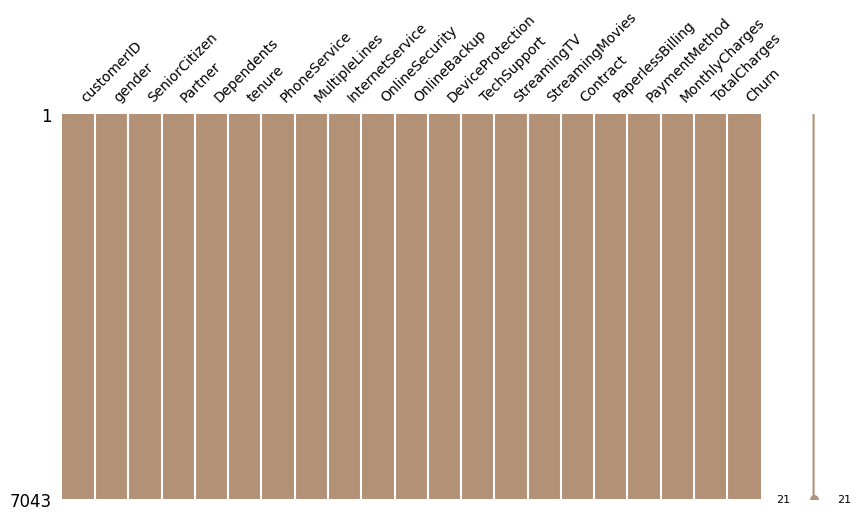

In [181]:
msno.matrix(dfDados, figsize=(10,5), fontsize=10, color=(0.7, 0.57, 0.47));


## **Condições de Balanceamento de Dados**

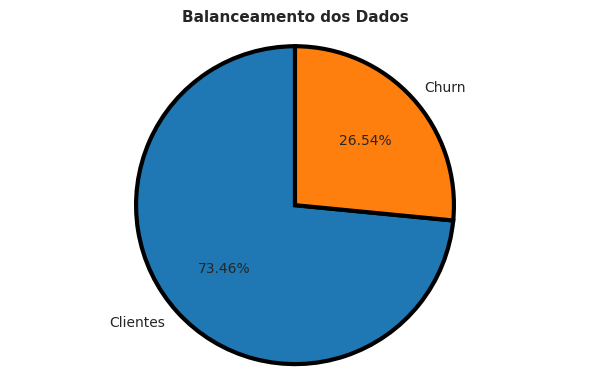

In [182]:
Labels = ["Clientes", "Churn"]
Quantidade = [dfDados["Churn"].value_counts()[0], dfDados["Churn"].value_counts()[1]]

Grafico = plt.figure( figsize=(6, 4))
sns.set_style("darkgrid")

plt.title("Balanceamento dos Dados", fontsize=11, fontweight="bold")
plt.pie (
        Quantidade,
        labels = Labels,
        autopct = "%1.2f%%",
        wedgeprops = {
                        "linewidth" : 3,
                        "edgecolor" : "black"
                     },
        startangle=90
        )

plt.axis("equal")
plt.tight_layout()
plt.show()

del (Labels, Quantidade, Grafico)


## **Mapa de Correlação dos Dados**

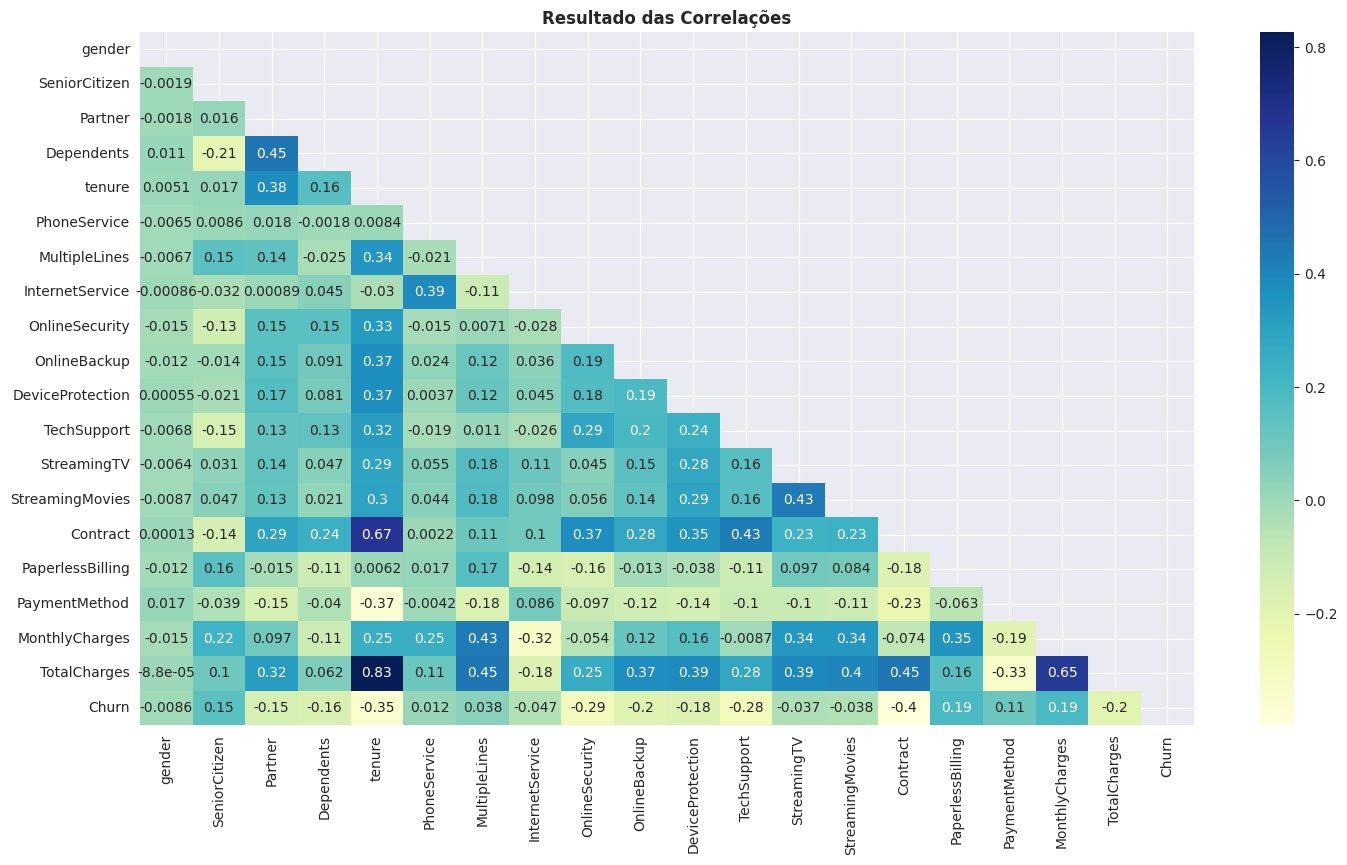

In [197]:
dfTemp = dfDados.copy()
dfTemp = dfTemp.drop(["customerID"], axis=1)

plt.figure(figsize=(17, 9))
Mascara = np.triu(np.ones_like(dfTemp.corr()))
dfNovo = dfTemp.corr()
plt.title("Resultado das Correlações", fontsize=12, fontweight="bold" )
sns.heatmap(dfTemp.corr(), cmap="YlGnBu", annot=True, mask=Mascara)
plt.show()

# del (dfTemp, Mascara)


In [184]:
lstComponentes =    [ 
                    "gender",
                    "SeniorCitizen",
                    "Partner",	
                    "Dependents",	
                    "tenure",	
                    "PhoneService",	
                    "MultipleLines",	
                    "InternetService",	
                    "OnlineSecurity",	
                    "OnlineBackup",	
                    "DeviceProtection",	
                    "TechSupport",	
                    "StreamingTV",	
                    "StreamingMovies",	
                    "Contract",	
                    "PaperlessBilling",	
                    "PaymentMethod",	
                    "MonthlyCharges",	
                    "TotalCharges",	
                    "Churn"
                    ]


In [188]:
def cramerV(label,x):
    confusion_matrix = pd.crosstab(label, x)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r,k = confusion_matrix.shape
    phi2 = chi2/n
    phi2corr = max(0,phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r - 1) ** 2) / ( n - 1 )
    kcorr = k - ((k - 1) ** 2) / ( n - 1 )
    try:
        if min((kcorr - 1),(rcorr - 1)) == 0:
            warnings.warn(
            "Erro no Calculado do Cramer V",RuntimeWarning)
            v = 0
        else:
            v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
    except:
        v = 0
    return v

def plot_cramer(df):
    cramer = pd.DataFrame(index=df.columns,columns=df.columns)
    for column_of_interest in df.columns:
        try:
            temp = {}

            columns = df.columns
            for j in range(0,len(columns)):
                v = cramerV(df[column_of_interest],df[columns[j]])
                cramer.loc[column_of_interest,columns[j]] = v
                if (column_of_interest==columns[j]):
                    pass
                else:
                    temp[columns[j]] = v
            cramer.fillna(value=np.nan,inplace=True)
        except:
            pass

    return (cramer)
       
dfLixo = plot_cramer(dfTemp)    


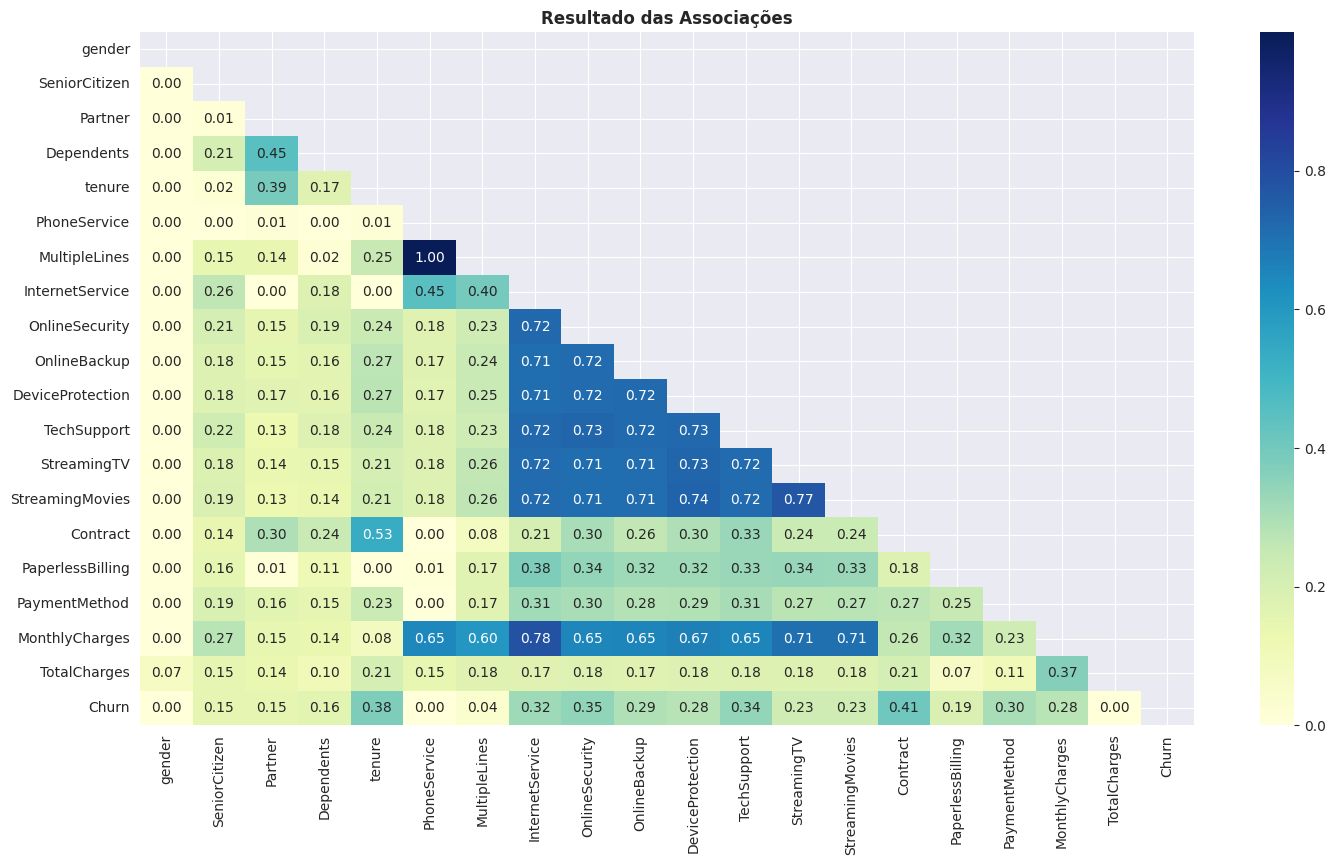

In [195]:
dfFraca = dfLixo.copy()           
plt.figure(figsize=(17, 9))
Mascara = np.triu(np.ones_like(dfFraca))
plt.title("Resultado das Associações", fontsize=12, fontweight="bold" )
sns.heatmap(dfFraca, cmap="YlGnBu", annot=True,fmt='.2f', mask=Mascara)    
plt.show()

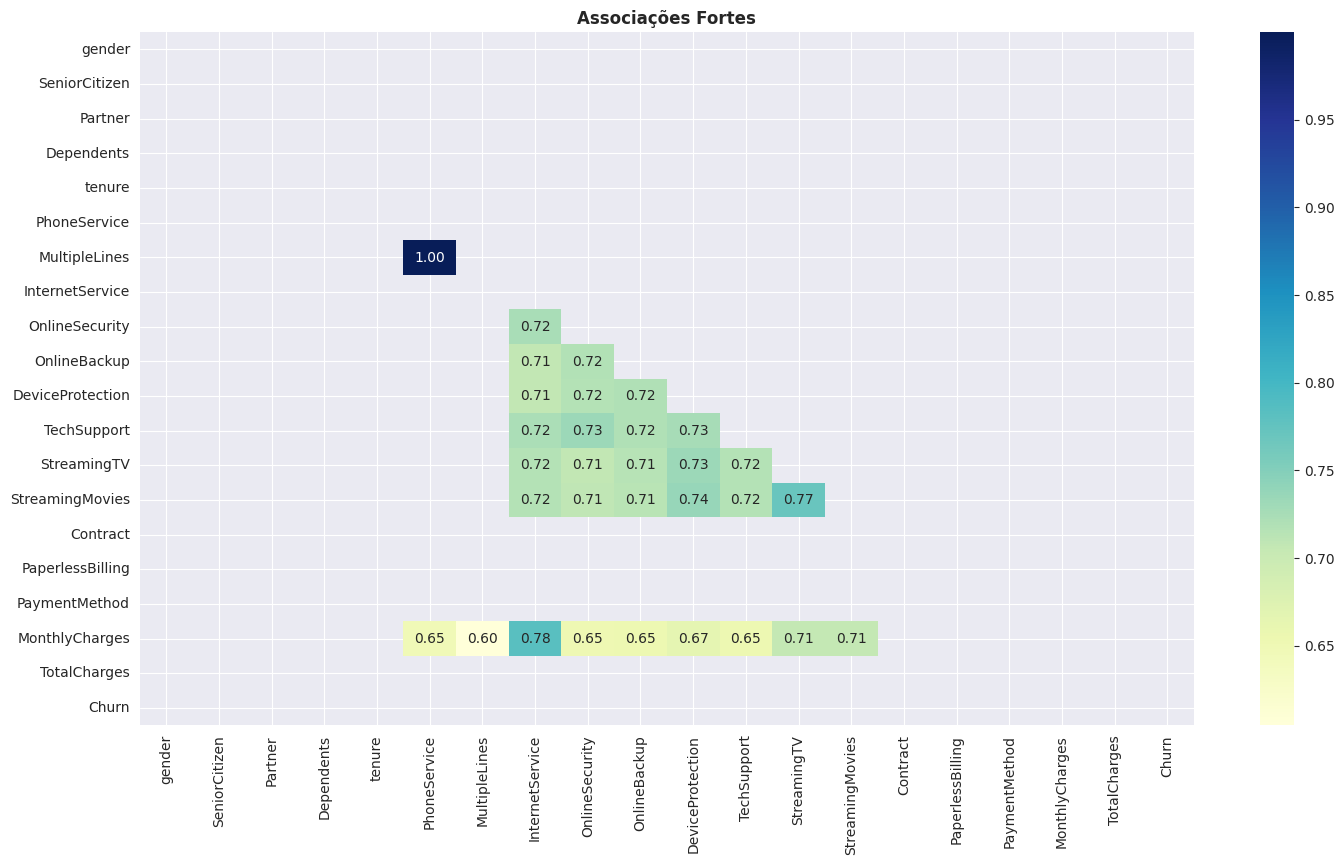

In [189]:
dfFraca = dfLixo.copy()
for iAux in lstComponentes:
    for jAux in lstComponentes:
        if (dfFraca [iAux][jAux] < 0.6):
            dfFraca [iAux][jAux] = np.nan 
            
plt.figure(figsize=(17, 9))
Mascara = np.triu(np.ones_like(dfFraca))
plt.title("Associações Fortes", fontsize=12, fontweight="bold" )
sns.heatmap(dfFraca, cmap="YlGnBu", annot=True,fmt='.2f', mask=Mascara)    
plt.show()

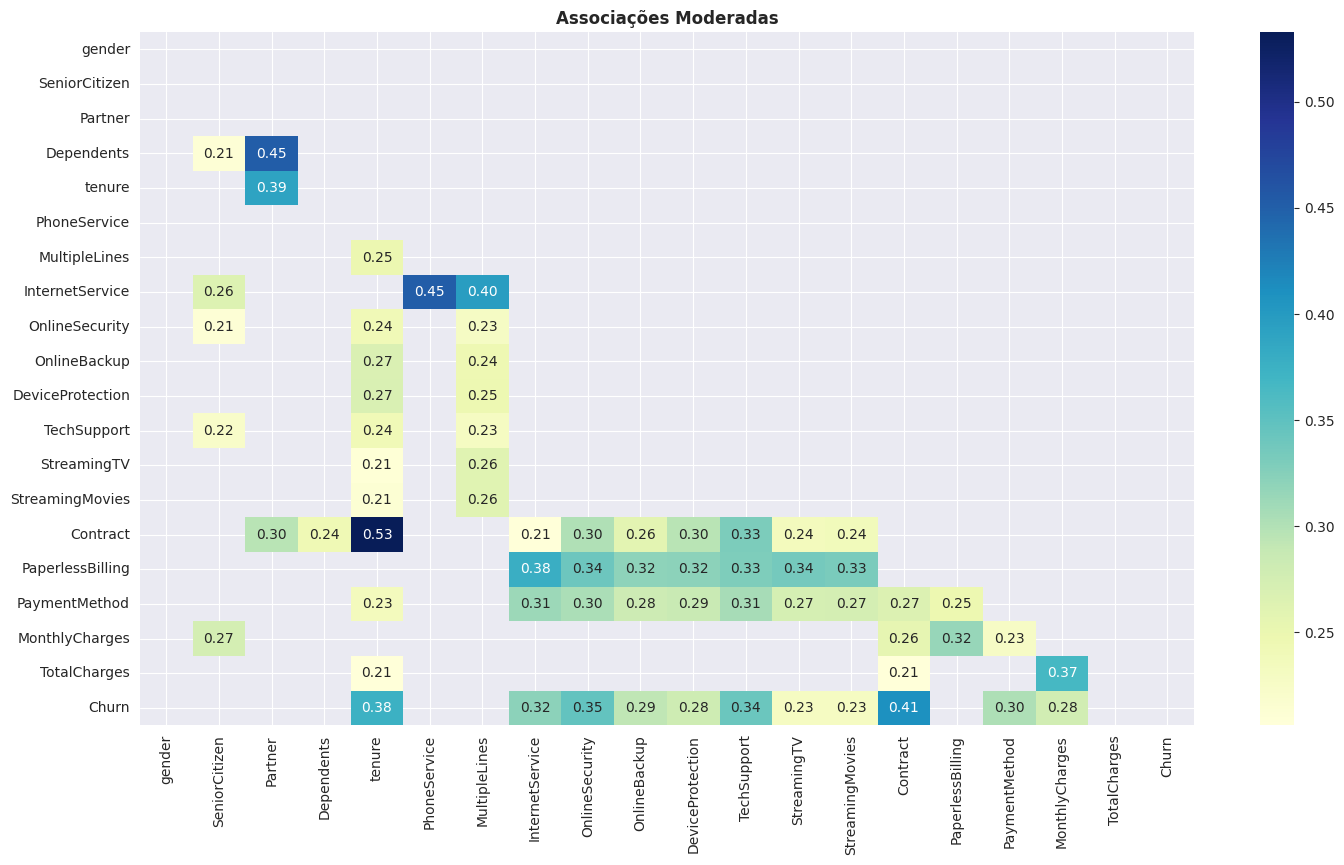

In [190]:
dfFraca = dfLixo.copy()
for iAux in lstComponentes:
    for jAux in lstComponentes:
        if (dfFraca [iAux][jAux] > 0.2) and (dfFraca [iAux][jAux] <= 0.6):
            dfFraca [iAux][jAux] = dfFraca [iAux][jAux]
        else:
            dfFraca [iAux][jAux] = np.nan 
            
plt.figure(figsize=(17, 9))
Mascara = np.triu(np.ones_like(dfFraca))
plt.title("Associações Moderadas", fontsize=12, fontweight="bold" )
sns.heatmap(dfFraca, cmap="YlGnBu", annot=True,fmt='.2f', mask=Mascara)    
plt.show()

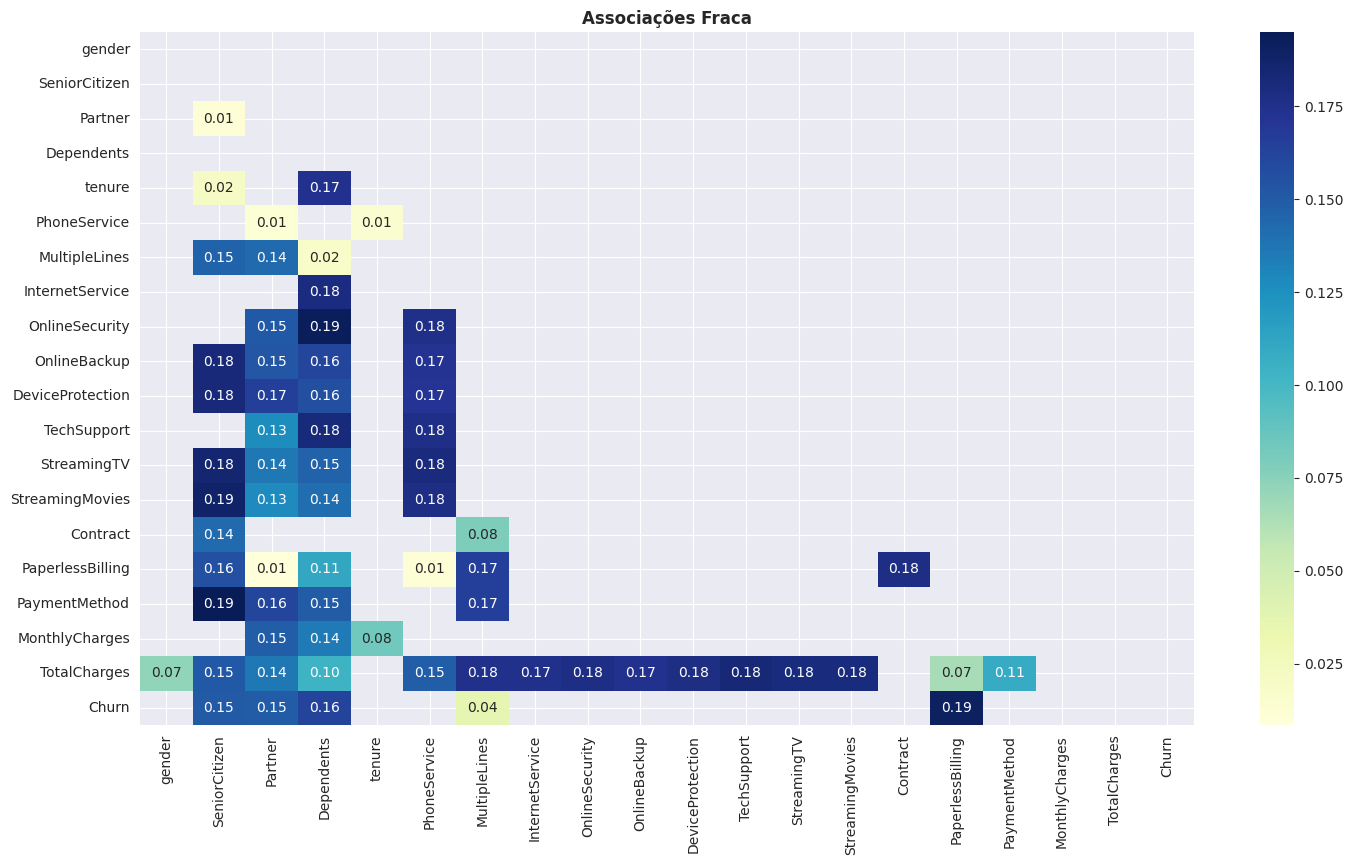

In [193]:
dfFraca = dfLixo.copy()
for iAux in lstComponentes:
    for jAux in lstComponentes:

        if round(dfFraca[iAux][jAux],2) == 0.0:
            dfFraca[iAux][jAux] = np.nan
        elif dfFraca[iAux][jAux] <= 0.2:
            dfFraca[iAux][jAux] = dfFraca[iAux][jAux]
        else:
            dfFraca[iAux][jAux] = np.nan
            
plt.figure(figsize=(17, 9))
Mascara = np.triu(np.ones_like(dfFraca))
plt.title("Associações Fraca", fontsize=12, fontweight="bold" )
sns.heatmap(dfFraca, cmap="YlGnBu", annot=True,fmt='.2f', mask=Mascara)    
plt.show()